# Title: Brexit under the lens

<p align="center">
  <img width="460" height="300" src="https://www.dachser.com/en/mediaroom/images/Corporate/Marktinformation/shutterstock_417868516_rdax_65.jpg">
</p>

# Import Libraries

In [1]:
# Load the data folder in the share drives
# The data folder is in the 'drive/Shareddrives/Ada'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Downgrade the pandas version so that we can read data in chunksize
!pip install pandas==1.0.5

     |████████████████████████████████| 10.1 MB 5.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.0.5 which is incompatible.


In [3]:
!pip install textblob

In [4]:
# Import library
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import warnings
import pickle
import shutil
import os
import glob
import wordcloud
import nltk
import re
warnings.filterwarnings('ignore')

import requests 
from bs4 import BeautifulSoup

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
import sys
import spacy
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [7]:
# NLTK Stop words
#from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Data collection

In [8]:
# The original datafile path, contains all the Quote from 2015-2020
dataset_path='/content/drive/Shareddrives/Ada/Quotebank'

# The path store the first preprocessed Pickles 
pickle_path='/content/drive/Shareddrives/Ada/pickle'

# Specify which cols to drop and which to keep
use_cols=["qids","quoteID","quotation","speaker","date","numOccurrences","probas","urls","phase"]
ignore_cols=[]

# The chunk_size for the pickles
chunk_size = 600000 

In [ ]:
# Only run this block when remove the pickles and make new pickles
shutil.rmtree(pickle_path)
os.mkdir(pickle_path)

In [9]:
# Check if the data has been processed and saved into pickles already 
# If not, process raw data into pickles
if not os.listdir(pickle_path):
   for name in glob.glob(dataset_path + "/*.bz2"):
     print("pickling "+name)
     pickle_name=name.split('/')[6].split('.')[0]
     reader = pd.read_json(name, chunksize=chunk_size, lines=True, compression='bz2')   
     for i, chunk in enumerate(reader):
       chunk=chunk[use_cols]
       out_file = pickle_path + "/"+ pickle_name + "_{}.pkl".format(i+1)
       with open(out_file, "wb") as f:
           pickle.dump(chunk,f,pickle.HIGHEST_PROTOCOL)
       chunk=""    
   print('Pickles made!,ready to go!')       
else:    
   print("Already processed data into pickles, you can use them right away!")

Already processed data into pickles, you can use them right away!


In [10]:
# Filter the pickles and extract Brexit related data
# Define the path to store the processed pickle
processed_path='/content/drive/Shareddrives/Ada/processed' 
out_file = processed_path + "/"+"Brexit_related_quote.pkl"

# Specify the orginal pickles we want to process
if not os.path.exists(out_file):
  data_p_files=[]
  for name in glob.glob(pickle_path + "/*.pkl"):
    data_p_files.append(name)

  # Add all the df into here and store it into pickle in the end
  appended_data=[]
  for i in range(len(data_p_files)):
    print("processing"+data_p_files[i])
    df=pd.read_pickle(data_p_files[i])
    # Filter quotations only in phase E
    df=df.loc[df['phase']=='E']
    df=df.loc[df['speaker']!='None']
    # Filter quotations only relevant to Brexit or both UK and EU firtsly
    df=df.loc[df['quotation'].str.contains('Brexit|UK.*EU|EU.*UK|United Kingdom.*European Union|European Union.*United Kingdom|British.*EU|EU.*British',case = False)]
    # Define key words relevant to Brexit to filter related news from the quotations that only relevant to UK and EU 
    searchfor = ['brexit','leave campaign and remain campaign','no deal', 'transition period','leave','withdral','referendum', 'split from']
    # Filter quotations which contained (EU and UK) or (Breix) which also contained those keywords we defined above
    df=df.loc[df['quotation'].str.contains('|'.join(searchfor),case = False)]

    appended_data.append(df)
    # release the df at the end of process
    # To free the memory
    df = ""  
    
    # concat and append results
    appended_data = pd.concat(appended_data)
    appended_data.to_pickle(out_file)
else:    
   print("Already processed data into pickle, you can use them right away!")

Already processed data into pickle, you can use them right away!


In [ ]:
# Merge the original Brexit related quotation dataset with speaker attributes by joining the QIDs
# Define the output pickle path
all_attribute_pickle_path='/content/drive/Shareddrives/Ada/processed/All_attribute.pkl'
if not os.path.exists(all_attribute_pickle_path):
  parquet_path='/content/drive/Shareddrives/Ada/Project datasets/speaker_attributes.parquet'
  label_path='/content/drive/Shareddrives/Ada/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2'
  df=pd.read_pickle('/content/drive/Shareddrives/Ada/processed/Brexit_related_quote.pkl')
  df['qids']=df['qids'].map(lambda x:str(x[0]))
  df.rename(columns={"qids":"id"},inplace=True)
  parquet_cols=['id','label','date_of_birth','nationality','gender','ethnic_group','occupation','party','academic_degree','religion']

  # recursively add the cols and update to our dataframe
  for name in glob.glob(parquet_path + "/*.parquet"):
    par=pd.read_parquet(name)
    par=par[parquet_cols]
    #Check if the merge has been done
    if 'gender' not in df.columns:
      df = pd.merge(df, par,on='id',how='left')
    else:
      df=df.set_index('id')
      df.update(par.set_index('id'))
      df.reset_index(inplace=True)
  
  # Replace NAN with value 0 in order to make the following process become easy
  df = df.fillna('0')
  cols=['nationality','gender','ethnic_group','occupation','party','academic_degree','religion']

  # Always keep the first qid label
  for col in cols:
    df[col]=df[col].map(lambda x: x[0])

  df_label=pd.read_csv(label_path,compression='bz2',index_col='QID')
  # replace the qid with actuall text label
  for col in cols:
    df[col]=df[col].map(lambda x: df_label.loc[x]['Label'] if x in df_label.index else x)
  df.to_pickle(all_attribute_pickle_path)

In [11]:
# Read the dataset after merging with speaker attributes
df=pd.read_pickle('/content/drive/Shareddrives/Ada/processed/All_attribute.pkl')
df.head(5)

,id,quoteID,quotation,speaker,probas,date,numOccurrences,urls,phase,label,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,religion
0,Q20251661,2020-01-31-011304,Brexit is the victory of the common people aga...,Laura Huhtasaari,"[[Laura Huhtasaari, 0.9325], [None, 0.059], [P...",2020-01-31 03:25:04,1,[http://voanews.com/europe/shrug-and-some-sorr...,E,Laura Huhtasaari,[+1979-03-30T00:00:00Z],Finland,female,0,politician,Finns Party,0,Lutheranism
1,Q694676,2020-02-13-014393,Certainly Brexit was a big issue and people we...,Pat McFadden,"[[Pat McFadden, 0.9371], [None, 0.0535], [Jere...",2020-02-13 06:01:30,1,[http://www.expressandstar.com/news/politics/2...,E,Pat McFadden,[+1965-03-26T00:00:00Z],United Kingdom,male,0,politician,Labour Party,0,0
2,Q1341937,2020-03-08-010480,"I backed leave and voted leave, but I never ca...",Jason McCartney,"[[Jason McCartney, 0.8274], [None, 0.128], [Li...",2020-03-08 05:45:58,1,[http://www.yorkshirepost.co.uk/news/second-ti...,E,Jason McCartney,[+1973-09-03T00:00:00Z],United States of America,male,0,sport cyclist,0,0,0
3,Q6837191,2020-02-14-058019,"legacy, bad faith on pensions, Brexit and poli...",Michelle O'Neill,"[[Michelle O'Neill, 0.8055], [None, 0.1302], [...",2020-02-14 11:48:49,1,[https://www.belfasttelegraph.co.uk/news/north...,E,Michelle O'Neill,[+1977-01-10T00:00:00Z],Northern Ireland,female,0,politician,Sinn Féin,0,0
4,Q1728820,2020-01-27-094916,"we're only at half-time on Brexit, it's not do...",Leo Varadkar,"[[Leo Varadkar, 0.9378], [None, 0.0502], [Bori...",2020-01-27 12:25:00,1,[http://blogs.independent.co.uk/voices/brexit-...,E,Leo Varadkar,[+1979-01-18T00:00:00Z],Ireland,male,0,politician,Fine Gael,0,0


# Preliminary Analysis

## How many quotations related to Brexit

In [ ]:
df.shape[0]

101878

We thus have more thant 101 thousands datapoints containing quotations we judge related to Brexit. We consider it enough to run the analysis.

## Visualise keywords of quotations via word cloud

Preprocess quotations for generating word cloud

In [ ]:
# Remove punctuation
df['quotation_processed'] = \
df["quotation"].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
df['quotation_processed'] = \
df['quotation_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
df['quotation_processed'].head()

0    brexit is the victory of the common people aga...
1    certainly brexit was a big issue and people we...
2    i backed leave and voted leave but i never cal...
3    legacy bad faith on pensions brexit and politi...
4    we're only at half-time on brexit it's not don...
Name: quotation_processed, dtype: object

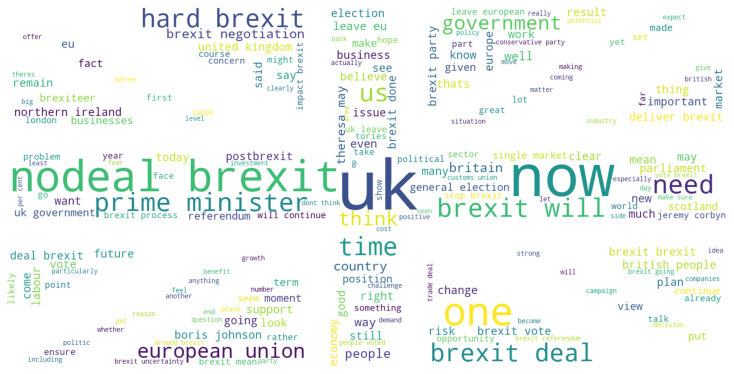

In [ ]:
# Generate the wordcloud
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import string
quotation_words = ''
stopwords = set(STOPWORDS) 
qute_txt='/content/drive/Shareddrives/Ada/processed/qutos_trial_lda.txt'

if not os.path.exists(qute_txt):
  with open(qute_txt,"w+") as f:
    # iterate through the csv file 
    for val in df.quotation_processed: 
      # typecaste each val to string 
      val = str(val)
      for c in string.punctuation:
        val = val.replace(c,'') 
      # split the value 
      tokens = val.split() 
      #Converts each token into lowercase 
      for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
      for words in tokens: 
        f.write(str(words)+ '\n')
  f.close()

quotation_words=open (qute_txt).read()
mask = np.array(Image.open('/content/drive/Shareddrives/Ada/img/Flag_of_the_United_Kingdom.png'))
wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            mask=mask,
            stopwords = stopwords, 
            min_font_size = 10).generate(quotation_words) 

# plot the WordCloud image                        
plt.figure(figsize = (10, 20), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 
## stop words

As we defined some keywords to filter some Brexit related quotations, some of words shown in word cloud such as "brexit", "UK", "nodeal", "european union" are those keywords we defined in previous section. There are still some interesting keywords shown in the graph, such as "hard brexit", "boris johnson", "theresa may", "labour", "economy", "prime minister" etc.

# Sentiment analysis 

## Method 1: using package TextBlob

In [42]:
df=pd.read_pickle('/content/drive/Shareddrives/Ada/processed/All_attribute.pkl')

In [43]:
df.columns

Index(['id', 'quoteID', 'quotation', 'speaker', 'probas', 'date',
       'numOccurrences', 'urls', 'phase', 'label', 'date_of_birth',
       'nationality', 'gender', 'ethnic_group', 'occupation', 'party',
       'academic_degree', 'religion'],
      dtype='object')

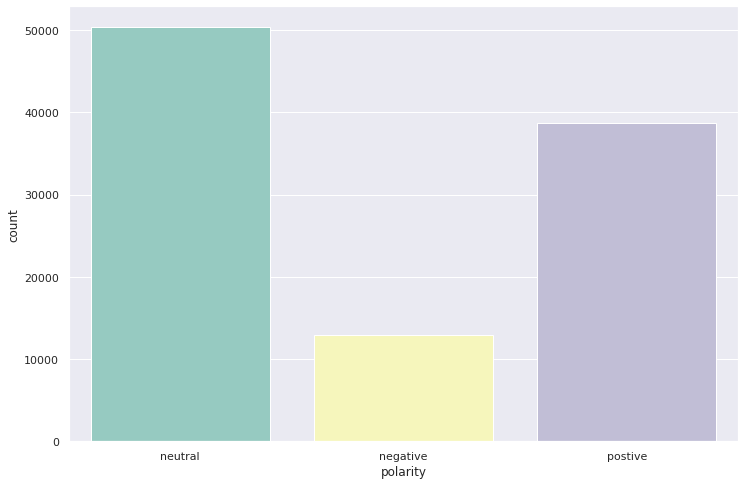

In [44]:
# perform a naive sentimental analysis
from textblob import TextBlob
if 'polarity' not in df.columns:
  df.insert(df.shape[1],'polarity','None')

# this function simply return the sentiment classification for the scentence
def polarity_to_text(blob):  
      if (blob.sentiment.polarity > 0.1):
        #'Polarity is positive 😊'
          return 'postive'
      elif(blob.sentiment.polarity <= 0.1 and  blob.sentiment.polarity >= -0.1):
          # 'Polarity is neutral 😐'
          return 'neutral'
      else:
        # 'Polarity is negative 😡' 
          return 'negative'

def get_polarity(blob):
  return blob.sentiment.polarity

if df.iloc[1].polarity=="None":
  for i,data in df.iterrows():
    blob = TextBlob(data.quotation)
    emotion=polarity_to_text(blob)
    polarity= get_polarity(blob)
    df.at[i,'polarity_TextBlob']=polarity
    df.at[i,'polarity']=emotion



plt.figure(figsize=(12,8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="polarity", data=df,palette="Set3")
plt.show()

In [45]:
df.columns

Index(['id', 'quoteID', 'quotation', 'speaker', 'probas', 'date',
       'numOccurrences', 'urls', 'phase', 'label', 'date_of_birth',
       'nationality', 'gender', 'ethnic_group', 'occupation', 'party',
       'academic_degree', 'religion', 'polarity', 'polarity_TextBlob'],
      dtype='object')

Because we don't really need the result of each method since we will average, we drop it:

In [46]:
df=df.drop(['polarity'], axis=1)
df.columns

Index(['id', 'quoteID', 'quotation', 'speaker', 'probas', 'date',
       'numOccurrences', 'urls', 'phase', 'label', 'date_of_birth',
       'nationality', 'gender', 'ethnic_group', 'occupation', 'party',
       'academic_degree', 'religion', 'polarity_TextBlob'],
      dtype='object')

In [ ]:
df.to_pickle('/content/drive/Shareddrives/Ada/SentimentAnalysis_temp.pkl')

According to our first sentiment analysis result, most of quotations reflect neutral attitude towards Brexit. It's noticeable that amount of quotations showing positive attitudes is much higher than showing negative attitudes. But, those results may not accurate. We will update the sentiment analysis in milestone 3!

## Method 2: using package Sentiment Intensity Analyser

In [47]:
from nltk.sentiment import SentimentIntensityAnalyzer
import operator
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [48]:
#defining our model:
sia = SentimentIntensityAnalyzer()

# score of sentiment analysis
df["polarity_SentimentIntensityAnalyze"] = df['quotation'].apply(lambda x: sia.polarity_scores(x)["compound"])


In [49]:
df.columns

Index(['id', 'quoteID', 'quotation', 'speaker', 'probas', 'date',
       'numOccurrences', 'urls', 'phase', 'label', 'date_of_birth',
       'nationality', 'gender', 'ethnic_group', 'occupation', 'party',
       'academic_degree', 'religion', 'polarity_TextBlob',
       'polarity_SentimentIntensityAnalyze'],
      dtype='object')

In [ ]:
df.head()

In [57]:
df['polarity_SentimentIntensityAnalyze'][1]

-0.25

In [60]:
if 'emotion_SentimentIntensityAnalyze' not in df.columns:
  df.insert(df.shape[1],'emotion_SentimentIntensityAnalyze','None')

def polarity_to_text2(row):  
      if (row> 0.1):
        #'Polarity is positive 😊'
          return 'postive'
      elif(row <= 0.1 and  row >= -0.1):
          # 'Polarity is neutral 😐'
          return 'neutral'
      else:
        # 'Polarity is negative 😡' 
          return 'negative'



for i in range(len(df)):
  df.at[i,'emotion_SentimentIntensityAnalyze']=polarity_to_text2(df['polarity_SentimentIntensityAnalyze'][i])


In [61]:
df.head()

,id,quoteID,quotation,speaker,probas,date,numOccurrences,urls,phase,label,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,religion,polarity_TextBlob,polarity_SentimentIntensityAnalyze,emotion_SentimentIntensityAnalyze
0,Q20251661,2020-01-31-011304,Brexit is the victory of the common people aga...,Laura Huhtasaari,"[[Laura Huhtasaari, 0.9325], [None, 0.059], [P...",2020-01-31 03:25:04,1,[http://voanews.com/europe/shrug-and-some-sorr...,E,Laura Huhtasaari,[+1979-03-30T00:00:00Z],Finland,female,0,politician,Finns Party,0,Lutheranism,-0.022619,0.5719,postive
1,Q694676,2020-02-13-014393,Certainly Brexit was a big issue and people we...,Pat McFadden,"[[Pat McFadden, 0.9371], [None, 0.0535], [Jere...",2020-02-13 06:01:30,1,[http://www.expressandstar.com/news/politics/2...,E,Pat McFadden,[+1965-03-26T00:00:00Z],United Kingdom,male,0,politician,Labour Party,0,0,-0.161905,-0.2500,negative
2,Q1341937,2020-03-08-010480,"I backed leave and voted leave, but I never ca...",Jason McCartney,"[[Jason McCartney, 0.8274], [None, 0.128], [Li...",2020-03-08 05:45:58,1,[http://www.yorkshirepost.co.uk/news/second-ti...,E,Jason McCartney,[+1973-09-03T00:00:00Z],United States of America,male,0,sport cyclist,0,0,0,0.000000,-0.4243,negative
3,Q6837191,2020-02-14-058019,"legacy, bad faith on pensions, Brexit and poli...",Michelle O'Neill,"[[Michelle O'Neill, 0.8055], [None, 0.1302], [...",2020-02-14 11:48:49,1,[https://www.belfasttelegraph.co.uk/news/north...,E,Michelle O'Neill,[+1977-01-10T00:00:00Z],Northern Ireland,female,0,politician,Sinn Féin,0,0,-0.233333,-0.0516,neutral
4,Q1728820,2020-01-27-094916,"we're only at half-time on Brexit, it's not do...",Leo Varadkar,"[[Leo Varadkar, 0.9378], [None, 0.0502], [Bori...",2020-01-27 12:25:00,1,[http://blogs.independent.co.uk/voices/brexit-...,E,Leo Varadkar,[+1979-01-18T00:00:00Z],Ireland,male,0,politician,Fine Gael,0,0,0.000000,0.0000,neutral


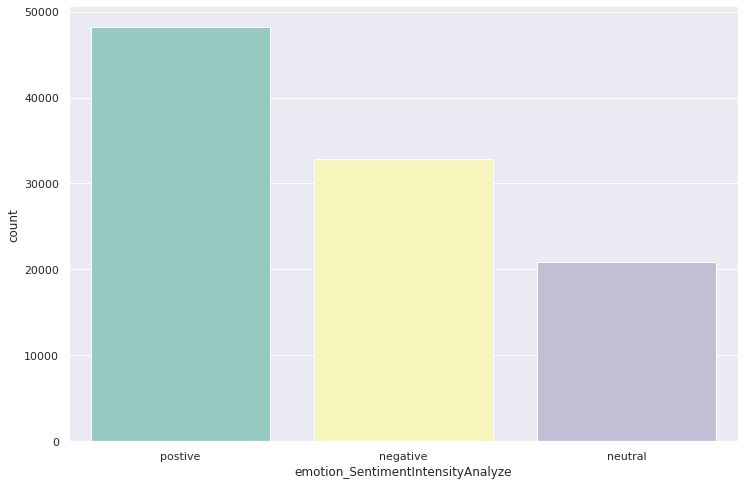

In [62]:
plt.figure(figsize=(12,8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion_SentimentIntensityAnalyze", data=df,palette="Set3")
plt.show()

In [63]:
# again dropping the result:
df=df.drop(['emotion_SentimentIntensityAnalyze'], axis=1)
df.columns

Index(['id', 'quoteID', 'quotation', 'speaker', 'probas', 'date',
       'numOccurrences', 'urls', 'phase', 'label', 'date_of_birth',
       'nationality', 'gender', 'ethnic_group', 'occupation', 'party',
       'academic_degree', 'religion', 'polarity_TextBlob',
       'polarity_SentimentIntensityAnalyze'],
      dtype='object')

In [105]:
df.to_pickle('/content/drive/Shareddrives/Ada/SentimentAnalysis_temp.pkl')

Method 3: Using the Flair Package:

In [40]:
!pip install flair

     |████████████████████████████████| 322 kB 5.3 MB/s 
     |████████████████████████████████| 788 kB 33.2 MB/s 
     |████████████████████████████████| 48 kB 5.1 MB/s 
     |████████████████████████████████| 19.7 MB 1.3 MB/s 
     |████████████████████████████████| 981 kB 21.9 MB/s 
     |████████████████████████████████| 3.1 MB 35.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 59 kB 6.4 MB/s 
     |████████████████████████████████| 1.2 MB 37.8 MB/s 
     |████████████████████████████████| 64 kB 2.7 MB/s 
     |████████████████████████████████| 62 kB 739 kB/s 
     |████████████████████████████████| 895 kB 37.4 MB/s 
     |████████████████████████████████| 3.3 MB 44.7 MB/s 
     |████████████████████████████████| 596 kB 43.5 MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9704 sha256=6988f665b05a1f5c6ee0d74801da3c169a53e8e49b1f5c

In [64]:
from flair.models import TextClassifier
from flair.data import Sentence
sia = TextClassifier.load('en-sentiment')

2021-11-27 10:06:50,742 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


In [103]:
def flair_prediction(x):
    sentence = Sentence(x)
    sia.predict(sentence)
    score = sentence.labels[0]
    if "POSITIVE" in str(score):
        return "positive"
    elif "NEGATIVE" in str(score):
        return "negative"
    else:
        return "neutral"

def flair_score(x):
    sentence = Sentence(x)
    sia.predict(sentence)
    score = sentence.labels[0].score
    return score


In [107]:
df["emotion_Flair"] = df["quotation"].apply(flair_prediction)

In [108]:
df["polarity_Flair"] = df["quotation"].apply(flair_score)

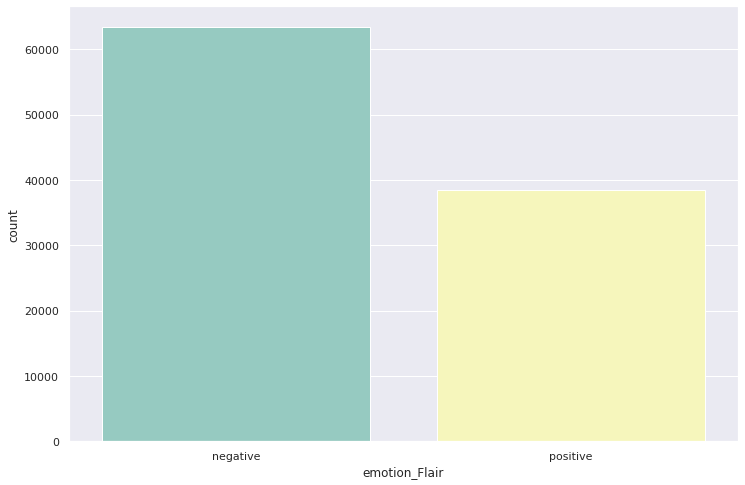

In [109]:
plt.figure(figsize=(12,8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion_Flair", data=df,palette="Set3")
plt.show()

Notice how here no neutral emotion was detected.

In [110]:
# again dropping the result:
df=df.drop(['emotion_Flair'], axis=1)
df.columns

Index(['id', 'quoteID', 'quotation', 'speaker', 'probas', 'date',
       'numOccurrences', 'urls', 'phase', 'label', 'date_of_birth',
       'nationality', 'gender', 'ethnic_group', 'occupation', 'party',
       'academic_degree', 'religion', 'polarity_TextBlob',
       'polarity_SentimentIntensityAnalyze', 'polarity_Flair'],
      dtype='object')

In [111]:
df.to_pickle('/content/drive/Shareddrives/Ada/SentimentAnalysis_temp.pkl')

In [112]:
df.head()

,id,quoteID,quotation,speaker,probas,date,numOccurrences,urls,phase,label,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,religion,polarity_TextBlob,polarity_SentimentIntensityAnalyze,polarity_Flair
0,Q20251661,2020-01-31-011304,Brexit is the victory of the common people aga...,Laura Huhtasaari,"[[Laura Huhtasaari, 0.9325], [None, 0.059], [P...",2020-01-31 03:25:04,1,[http://voanews.com/europe/shrug-and-some-sorr...,E,Laura Huhtasaari,[+1979-03-30T00:00:00Z],Finland,female,0,politician,Finns Party,0,Lutheranism,-0.022619,0.5719,0.663805
1,Q694676,2020-02-13-014393,Certainly Brexit was a big issue and people we...,Pat McFadden,"[[Pat McFadden, 0.9371], [None, 0.0535], [Jere...",2020-02-13 06:01:30,1,[http://www.expressandstar.com/news/politics/2...,E,Pat McFadden,[+1965-03-26T00:00:00Z],United Kingdom,male,0,politician,Labour Party,0,0,-0.161905,-0.2500,0.997470
2,Q1341937,2020-03-08-010480,"I backed leave and voted leave, but I never ca...",Jason McCartney,"[[Jason McCartney, 0.8274], [None, 0.128], [Li...",2020-03-08 05:45:58,1,[http://www.yorkshirepost.co.uk/news/second-ti...,E,Jason McCartney,[+1973-09-03T00:00:00Z],United States of America,male,0,sport cyclist,0,0,0,0.000000,-0.4243,0.595703
3,Q6837191,2020-02-14-058019,"legacy, bad faith on pensions, Brexit and poli...",Michelle O'Neill,"[[Michelle O'Neill, 0.8055], [None, 0.1302], [...",2020-02-14 11:48:49,1,[https://www.belfasttelegraph.co.uk/news/north...,E,Michelle O'Neill,[+1977-01-10T00:00:00Z],Northern Ireland,female,0,politician,Sinn Féin,0,0,-0.233333,-0.0516,0.951277
4,Q1728820,2020-01-27-094916,"we're only at half-time on Brexit, it's not do...",Leo Varadkar,"[[Leo Varadkar, 0.9378], [None, 0.0502], [Bori...",2020-01-27 12:25:00,1,[http://blogs.independent.co.uk/voices/brexit-...,E,Leo Varadkar,[+1979-01-18T00:00:00Z],Ireland,male,0,politician,Fine Gael,0,0,0.000000,0.0000,0.946059


Averaging the results:

In [121]:
df['polarity']=df[['polarity_Flair','polarity_TextBlob',
       'polarity_SentimentIntensityAnalyze']].mean(axis=1)

In [122]:
df.head()

,id,quoteID,quotation,speaker,probas,date,numOccurrences,urls,phase,label,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,religion,polarity_TextBlob,polarity_SentimentIntensityAnalyze,polarity_Flair,polarity
0,Q20251661,2020-01-31-011304,Brexit is the victory of the common people aga...,Laura Huhtasaari,"[[Laura Huhtasaari, 0.9325], [None, 0.059], [P...",2020-01-31 03:25:04,1,[http://voanews.com/europe/shrug-and-some-sorr...,E,Laura Huhtasaari,[+1979-03-30T00:00:00Z],Finland,female,0,politician,Finns Party,0,Lutheranism,-0.022619,0.5719,0.663805,0.404362
1,Q694676,2020-02-13-014393,Certainly Brexit was a big issue and people we...,Pat McFadden,"[[Pat McFadden, 0.9371], [None, 0.0535], [Jere...",2020-02-13 06:01:30,1,[http://www.expressandstar.com/news/politics/2...,E,Pat McFadden,[+1965-03-26T00:00:00Z],United Kingdom,male,0,politician,Labour Party,0,0,-0.161905,-0.2500,0.997470,0.195188
2,Q1341937,2020-03-08-010480,"I backed leave and voted leave, but I never ca...",Jason McCartney,"[[Jason McCartney, 0.8274], [None, 0.128], [Li...",2020-03-08 05:45:58,1,[http://www.yorkshirepost.co.uk/news/second-ti...,E,Jason McCartney,[+1973-09-03T00:00:00Z],United States of America,male,0,sport cyclist,0,0,0,0.000000,-0.4243,0.595703,0.057134
3,Q6837191,2020-02-14-058019,"legacy, bad faith on pensions, Brexit and poli...",Michelle O'Neill,"[[Michelle O'Neill, 0.8055], [None, 0.1302], [...",2020-02-14 11:48:49,1,[https://www.belfasttelegraph.co.uk/news/north...,E,Michelle O'Neill,[+1977-01-10T00:00:00Z],Northern Ireland,female,0,politician,Sinn Féin,0,0,-0.233333,-0.0516,0.951277,0.222115
4,Q1728820,2020-01-27-094916,"we're only at half-time on Brexit, it's not do...",Leo Varadkar,"[[Leo Varadkar, 0.9378], [None, 0.0502], [Bori...",2020-01-27 12:25:00,1,[http://blogs.independent.co.uk/voices/brexit-...,E,Leo Varadkar,[+1979-01-18T00:00:00Z],Ireland,male,0,politician,Fine Gael,0,0,0.000000,0.0000,0.946059,0.315353


In [123]:
df.to_pickle('/content/drive/Shareddrives/Ada/SentimentAnalysis_temp.pkl')

Assigning the emotion to the averaged score:

In [124]:

for i in range(len(df)):
  df.at[i,'emotion']=polarity_to_text2(df['polarity'][i])

In [125]:
df.head()

,id,quoteID,quotation,speaker,probas,date,numOccurrences,urls,phase,label,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,religion,polarity_TextBlob,polarity_SentimentIntensityAnalyze,polarity_Flair,polarity,emotion
0,Q20251661,2020-01-31-011304,Brexit is the victory of the common people aga...,Laura Huhtasaari,"[[Laura Huhtasaari, 0.9325], [None, 0.059], [P...",2020-01-31 03:25:04,1,[http://voanews.com/europe/shrug-and-some-sorr...,E,Laura Huhtasaari,[+1979-03-30T00:00:00Z],Finland,female,0,politician,Finns Party,0,Lutheranism,-0.022619,0.5719,0.663805,0.404362,postive
1,Q694676,2020-02-13-014393,Certainly Brexit was a big issue and people we...,Pat McFadden,"[[Pat McFadden, 0.9371], [None, 0.0535], [Jere...",2020-02-13 06:01:30,1,[http://www.expressandstar.com/news/politics/2...,E,Pat McFadden,[+1965-03-26T00:00:00Z],United Kingdom,male,0,politician,Labour Party,0,0,-0.161905,-0.2500,0.997470,0.195188,postive
2,Q1341937,2020-03-08-010480,"I backed leave and voted leave, but I never ca...",Jason McCartney,"[[Jason McCartney, 0.8274], [None, 0.128], [Li...",2020-03-08 05:45:58,1,[http://www.yorkshirepost.co.uk/news/second-ti...,E,Jason McCartney,[+1973-09-03T00:00:00Z],United States of America,male,0,sport cyclist,0,0,0,0.000000,-0.4243,0.595703,0.057134,neutral
3,Q6837191,2020-02-14-058019,"legacy, bad faith on pensions, Brexit and poli...",Michelle O'Neill,"[[Michelle O'Neill, 0.8055], [None, 0.1302], [...",2020-02-14 11:48:49,1,[https://www.belfasttelegraph.co.uk/news/north...,E,Michelle O'Neill,[+1977-01-10T00:00:00Z],Northern Ireland,female,0,politician,Sinn Féin,0,0,-0.233333,-0.0516,0.951277,0.222115,postive
4,Q1728820,2020-01-27-094916,"we're only at half-time on Brexit, it's not do...",Leo Varadkar,"[[Leo Varadkar, 0.9378], [None, 0.0502], [Bori...",2020-01-27 12:25:00,1,[http://blogs.independent.co.uk/voices/brexit-...,E,Leo Varadkar,[+1979-01-18T00:00:00Z],Ireland,male,0,politician,Fine Gael,0,0,0.000000,0.0000,0.946059,0.315353,postive


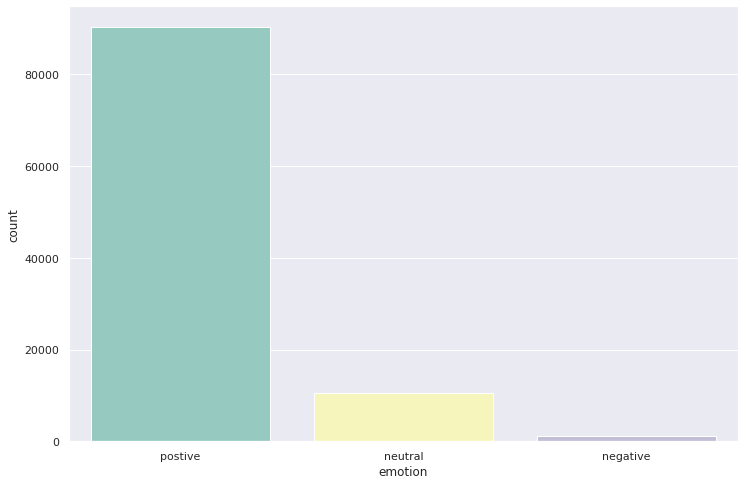

In [129]:
plt.figure(figsize=(12,8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=df,palette="Set3")
plt.show()

Putting everything in one pickel:

In [126]:
df.to_pickle('/content/drive/Shareddrives/Ada/SentimentAnalysis.pkl')

In [127]:
dummydf=pd.read_pickle('/content/drive/Shareddrives/Ada/SentimentAnalysis.pkl')

In [130]:
df.columns

Index(['id', 'quoteID', 'quotation', 'speaker', 'probas', 'date',
       'numOccurrences', 'urls', 'phase', 'label', 'date_of_birth',
       'nationality', 'gender', 'ethnic_group', 'occupation', 'party',
       'academic_degree', 'religion', 'polarity_TextBlob',
       'polarity_SentimentIntensityAnalyze', 'polarity_Flair', 'polarity',
       'emotion'],
      dtype='object')

## How did the number of quotations change over time?

In [ ]:
# Check the data type of date in dataframe
print(df.dtypes)

id                         object
quoteID                    object
quotation                  object
speaker                    object
probas                     object
date               datetime64[ns]
numOccurrences              int64
urls                       object
phase                      object
label                      object
date_of_birth              object
nationality                object
gender                     object
ethnic_group               object
occupation                 object
party                      object
academic_degree            object
religion                   object
dtype: object


In [ ]:
# Make Date column datetime
df['just_date'] = df['date'].dt.date
df['just_date'] = pd.to_datetime(df['just_date'], format='%Y-%m-%d')

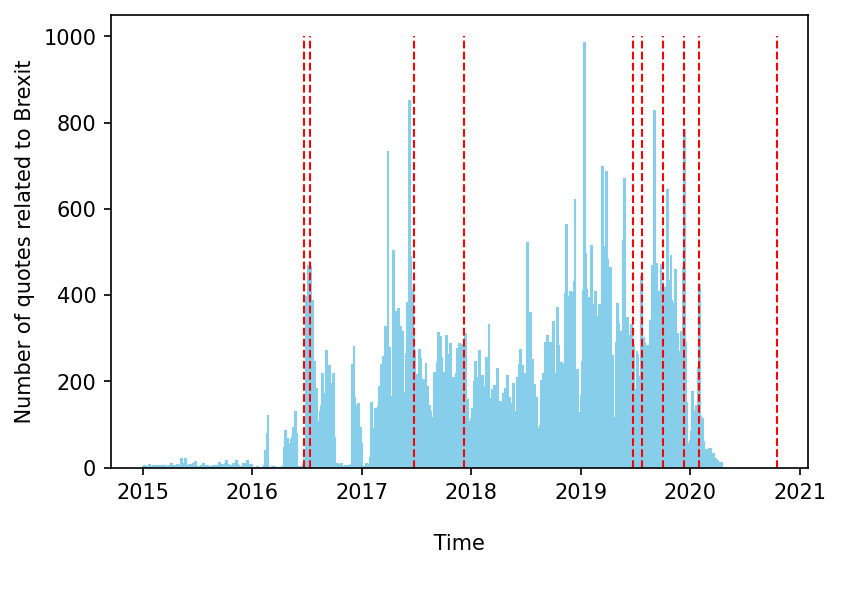

In [ ]:
#Plot the histogram to show the amount of quotations changed over 2015 to 2020
from datetime import datetime
fig, ax = plt.subplots()
fig.set_dpi(150)
ax.hist(df['just_date'], bins=700,color='skyblue', ec="skyblue");#,datetime(,,)
plt.xlabel('\n Time \n', fontsize = 10)
plt.ylabel(' Number of quotes related to Brexit ', fontsize = 10)
_ = ax.vlines(x=[datetime(2016, 6, 23),datetime(2016,7,13),datetime(2017,6,23),datetime(2017,12,8),datetime(2019,6,24),datetime(2019,7,24),datetime(2019,10,2),datetime(2019,12,12),datetime(2020,1,31),datetime(2020,10,16)], ymin=0, ymax=1000,linewidth=1,linestyle='--', colors='r')

## Initial analysis related to speakers


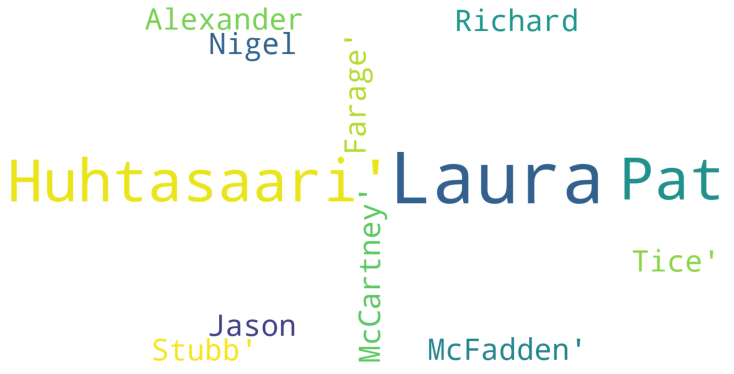

In [ ]:
# Generate  word cloud for speakers 
text = df['speaker'].values 
mask = np.array(Image.open('/content/drive/Shareddrives/Ada/img/Flag_of_the_United_Kingdom.png'))
wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            mask=mask,
            min_font_size = 10).generate(str(text))


# plot the WordCloud image                        
plt.figure(figsize = (10, 20), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

The wordcloud generated from speakers' data show some active speakers issued Brexit related quotations in Quotebank dataset.

In [ ]:
#Speakers
list_speakers = df['speaker']
list_speakers =list_speakers.to_list()

In [ ]:
set_unique_speakers = set(list_speakers)

In [ ]:
print("The number of unique speakers related to Brexit is: ", len(set_unique_speakers))

The number of unique speakers related to Brexit is:  15112


In [ ]:
# Count the number of quotations issued by each speaker
list_speakers_occurences = []
for speaker in set_unique_speakers:
  list_speakers_occurences.append([speaker, list_speakers.count(speaker)])
sorted_list_speakers_occurences = sorted(list_speakers_occurences, key=lambda x: x[1], reverse=True)

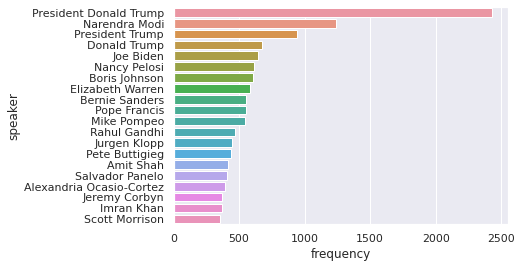

In [ ]:
# Rank speakers by the number of quotations issued
df_speakers = pd.DataFrame(sorted_list_speakers_occurences)
df_speakers.set_axis(['speaker', 'frequency'], axis=1, inplace=True)
import matplotlib.pyplot as plt
ax = sns.barplot(x="frequency", y="speaker", data=df_speakers.head(20))

The plot shows an interesting fact that Donald Trump commented on Brexit frequently. This perhaps due to Quotebank collect more quotations from American media. Narendra Modi who is the 14th Prime Minister of India is ranked at the second place. This may due to there are some frequent trade deals between UK and India. 

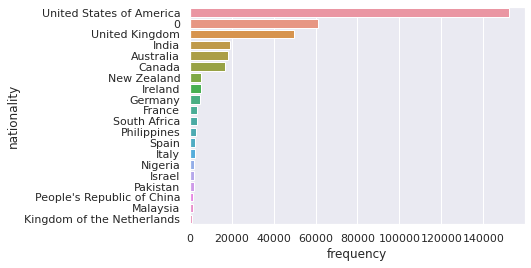

In [ ]:
# The plot shows the ranking of speaker's nationality by the amount of Brexit related quotations
df_attr=df
list_nationality = df_attr['nationality']
list_nationality =list_nationality.to_list()
set_unique_nationality = set(list_nationality)
list_nationality_occurences = []
for nationality in set_unique_nationality:
  list_nationality_occurences.append([nationality, list_nationality.count(nationality)])
sorted_list_nationality_occurences = sorted(list_nationality_occurences, key=lambda x: x[1], reverse=True)
df_nationality = pd.DataFrame(sorted_list_nationality_occurences)
df_nationality.set_axis(['nationality', 'frequency'], axis=1, inplace=True)
import matplotlib.pyplot as plt
ax = sns.barplot(x="frequency", y="nationality", data=df_nationality.head(20))

Most peakers are from America. "0" represents "NAN". Lots of speakers from United Kingdom, India and Australia. Except United Kingdom, other countries in top 5 are not European countries. This may due to the Quotebank only collect data from English news.

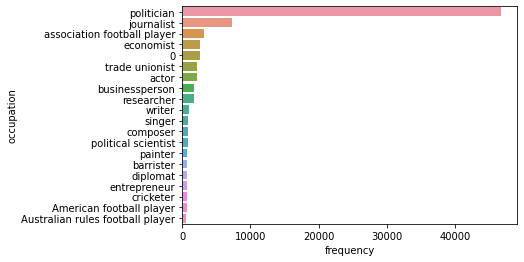

In [ ]:
# The plot shows the ranking of speaker's profession by the amount of Brexit related quotations
list_occupation = df_attr['occupation']
list_occupation =list_occupation.to_list()
set_unique_occupation = set(list_occupation)
list_occupation_occurences = []
for occupation in set_unique_occupation:
  list_occupation_occurences.append([occupation, list_occupation.count(occupation)])
sorted_list_occupation_occurences = sorted(list_occupation_occurences, key=lambda x: x[1], reverse=True)
df_occupation = pd.DataFrame(sorted_list_occupation_occurences)
df_occupation.set_axis(['occupation', 'frequency'], axis=1, inplace=True)
import matplotlib.pyplot as plt
ax = sns.barplot(x="frequency", y="occupation", data=df_occupation.head(20))

Politicians, journalists are most active speakers issued Brexit related quotations. This is due to Brexit is a political topic. It's interesting to see that association football player also keep active in a political topic. 

## Media (we defined as "domain" in following part) views towards Brexit:

**Adding the name of the domain (taking it from the url)**

In [ ]:
#Function tp change urls to domains
def function(row):
  list_domains = []
  for url in row:
    list_domains.append(urlparse(url).netloc)
  return list_domains

df['domains'] = df['urls'].apply(function)
df

,id,quoteID,quotation,speaker,probas,date,numOccurrences,urls,phase,label,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,religion,quotation_processed,domains
0,Q20251661,2020-01-31-011304,Brexit is the victory of the common people aga...,Laura Huhtasaari,"[[Laura Huhtasaari, 0.9325], [None, 0.059], [P...",2020-01-31 03:25:04,1,[http://voanews.com/europe/shrug-and-some-sorr...,E,Laura Huhtasaari,[+1979-03-30T00:00:00Z],Finland,female,0,politician,Finns Party,0,Lutheranism,brexit is the victory of the common people aga...,[voanews.com]
1,Q694676,2020-02-13-014393,Certainly Brexit was a big issue and people we...,Pat McFadden,"[[Pat McFadden, 0.9371], [None, 0.0535], [Jere...",2020-02-13 06:01:30,1,[http://www.expressandstar.com/news/politics/2...,E,Pat McFadden,[+1965-03-26T00:00:00Z],United Kingdom,male,0,politician,Labour Party,0,0,certainly brexit was a big issue and people we...,[www.expressandstar.com]
2,Q1341937,2020-03-08-010480,"I backed leave and voted leave, but I never ca...",Jason McCartney,"[[Jason McCartney, 0.8274], [None, 0.128], [Li...",2020-03-08 05:45:58,1,[http://www.yorkshirepost.co.uk/news/second-ti...,E,Jason McCartney,[+1973-09-03T00:00:00Z],United States of America,male,0,sport cyclist,0,0,0,i backed leave and voted leave but i never cal...,[www.yorkshirepost.co.uk]
3,Q6837191,2020-02-14-058019,"legacy, bad faith on pensions, Brexit and poli...",Michelle O'Neill,"[[Michelle O'Neill, 0.8055], [None, 0.1302], [...",2020-02-14 11:48:49,1,[https://www.belfasttelegraph.co.uk/news/north...,E,Michelle O'Neill,[+1977-01-10T00:00:00Z],Northern Ireland,female,0,politician,Sinn Féin,0,0,legacy bad faith on pensions brexit and politi...,[www.belfasttelegraph.co.uk]
4,Q1728820,2020-01-27-094916,"we're only at half-time on Brexit, it's not do...",Leo Varadkar,"[[Leo Varadkar, 0.9378], [None, 0.0502], [Bori...",2020-01-27 12:25:00,1,[http://blogs.independent.co.uk/voices/brexit-...,E,Leo Varadkar,[+1979-01-18T00:00:00Z],Ireland,male,0,politician,Fine Gael,0,0,we're only at half-time on brexit it's not don...,[blogs.independent.co.uk]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101873,Q567,2015-10-07-001521,a Brexit now [ look ] more likely,Angela Merkel,"[[Angela Merkel, 0.5723], [Francois Hollande, ...",2015-10-07 07:54:43,1,[http://breitbart.com/london/2015/10/07/farage...,E,Angela Merkel,[+1954-07-17T00:00:00Z],Germany,female,Germans,politician,Christian Democratic Union,doctorate,Evangelical Church in Germany,a brexit now [ look ] more likely,[breitbart.com]
101874,Q1395663,2015-03-10-096295,We saw strong growth in the UK last year but I...,Sir Martin Sorrell,"[[Sir Martin Sorrell, 0.8715], [None, 0.1285]]",2015-03-10 00:51:18,1,[http://independent.co.uk/news/business/news/w...,E,Martin Sorrell,[+1945-02-14T00:00:00Z],United Kingdom,male,0,businessperson,0,0,0,we saw strong growth in the uk last year but i...,[independent.co.uk]
101875,Q23769958,2015-10-09-130507,We look forward to supporting their push to pe...,Richard Tice,"[[Richard Tice, 0.9685], [None, 0.0262], [Davi...",2015-10-09 07:29:35,5,[http://feeds.theguardian.com/c/34708/f/663865...,E,Richard Tice,[+1964-09-13T00:00:00Z],United Kingdom,male,0,businessperson,Conservative Party,0,0,we look forward to supporting their push to pe...,"[feeds.theguardian.com, feeds.theguardian.com,..."
101876,Q503143,2015-08-24-049253,"It would be a travesty to both, for Europe and...",Alexander Stubb,"[[Alexander Stubb, 0.9019], [None, 0.0783], [G...",2015-08-24 11:37:42,7,[http://af.reuters.com/article/worldNews/idAFK...,E,Alexander Stubb,[+1968-04-01T00:00:00Z],Finland,male,Swedish-speaking population of Finland,politician,National Coalition Party,0,0,it would be a travesty to both for europe and ...,"[af.reuters.com, uk.news.yahoo.com, www.channe..."


In [ ]:
# Get the list of all domains and analyse them
list_domains = df['domains'].to_list()
flat_list_of_domains = [item for sublist in list_domains for item in sublist]

In [ ]:
set_unique_domains = set(flat_list_of_domains)

In [ ]:
print("The number of unique domains is ",len(set_unique_domains))

The number of unique domains is  6382


In [ ]:
list_domains_occurences = []
for domain in set_unique_domains:
  list_domains_occurences.append([domain, flat_list_of_domains.count(domain)])

In [ ]:
sorted_list_domains_occurences = sorted(list_domains_occurences, key=lambda x: x[1], reverse=True)

In [ ]:
# Get the top 5 domains
sorted_list_domains_occurences[0:5]

[['www.belfasttelegraph.co.uk', 6419],
 ['www.msn.com', 5989],
 ['express.co.uk', 5748],
 ['heraldscotland.com', 4728],
 ['www.wandsworthguardian.co.uk', 4601]]

In [ ]:
df_domains = pd.DataFrame.from_records(sorted_list_domains_occurences)

In [ ]:
# List the top 10 domains which relayed the information the most
df_domains.head(10)

,0,1
0,www.belfasttelegraph.co.uk,6419
1,www.msn.com,5989
2,express.co.uk,5748
3,heraldscotland.com,4728
4,www.wandsworthguardian.co.uk,4601
5,www.thetelegraphandargus.co.uk,4449
6,www.ealingtimes.co.uk,4308
7,www.croydonguardian.co.uk,4230
8,www.middevonstar.co.uk,4227
9,www.thenorthernecho.co.uk,4178


The Belfast Telegraph is a daily newspaper published in Belfast, Northern Ireland, by Independent News & Media. MSN.com is a visited portal website provided by Microsoft. The Daily Express and its sister paper - the Sunday Express are daily national middle-market and conservative tabloid newspapers in the United Kingdom. 

In [ ]:
df_domains.set_axis(['domain', 'frequency'], axis=1, inplace=True)

**Add percentages**

In [ ]:
df_domains['percentages'] = df_domains['frequency'].apply(lambda x: x / df.shape[0])

In [ ]:
df_domains

,domain,frequency,percentages
0,www.belfasttelegraph.co.uk,6419,0.063007
1,www.msn.com,5989,0.058786
2,express.co.uk,5748,0.056420
3,heraldscotland.com,4728,0.046408
4,www.wandsworthguardian.co.uk,4601,0.045162
...,...,...,...
6377,redalertpolitics.com,1,0.000010
6378,rdikeman.wordpress.com,1,0.000010
6379,www.commonwealmagazine.org,1,0.000010
6380,3noviceseurope.wordpress.com,1,0.000010


**Most invested domains**

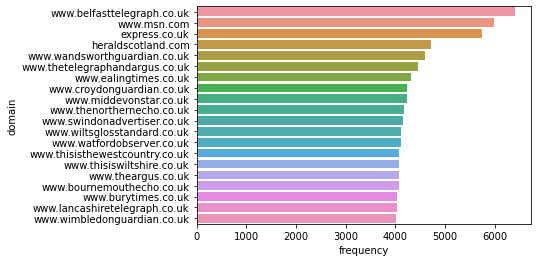

In [ ]:
# Visualise the top 10 media which relayed the information the most
import matplotlib.pyplot as plt
ax = sns.barplot(x="frequency", y="domain", data=df_domains.head(20))

**Counting frequency in UK**

In [ ]:
#Number of total quotes
total_quotes =df_domains['frequency'].sum()

In [ ]:
freq_uk = 0
for index, row in df_domains.iterrows():
  if row['domain'].endswith('uk'):
    freq_uk += row['frequency']

freq_uk

print('the percentage of the number of quotations in UK domains compared total: {:.2%}'.format(freq_uk/total_quotes))

the percentage of the number of quotations in UK domains compared total: 63.49%


Only looking at the domains we could find that most domains are based in UK as we expected.

**Scrapping the web page to get the domain countries using beautiful soup for future analysis**

In [ ]:
# Using beautiful soup to get the country of the domain
url = 'https://icannwiki.org/Country_code_top-level_domain'
r = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser')
ccTLD_table = soup.find('table')

table = []
for ccTLD in ccTLD_table.find_all('tbody'):
    rows = ccTLD.find_all('tr')
    for row in rows:
        columns = row.find_all('td')
        table.append([columns[0].text, columns[1].text])

In [ ]:
country_domain = pd.DataFrame(table)

In [ ]:
country_domain.columns = ['ccTLD', 'domain_country']
country_domain.drop(0,axis=0,inplace=True)
country_domain

,ccTLD,domain_country
1,.ac,Ascension Island
2,.ad,Andorra
3,.ae,United Arab Emirates
4,.af,Afghanistan
5,.ag,Antigua and Barbuda
...,...,...
250,.ws,Samoa
251,.yt,Mayote
252,.za,South Africa
253,.zm,Zambia


Above is just our initial analysis on Brexit related quotations. We will explore the dataset by following the research questions and methods proposed in README file. 